# Air Passengers Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts.datasets import AirPassengersDataset
from darts.utils.statistics import (
    plot_acf,
    plot_pacf,
    plot_hist,
    plot_residuals_analysis,
    check_seasonality,
    seasonal_decompose
)

from darts.metrics import mae, mape, mase, r2_score
from darts.models import (
    NaiveDrift,
    NaiveSeasonal,
    ARIMA,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)

import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.CRITICAL)

from darts_forecasting_utils import *

In [2]:
airpassengers = AirPassengersDataset().load()

In [3]:
train, test = airpassengers.split_before(pd.Timestamp('19600101'))

## Data Description

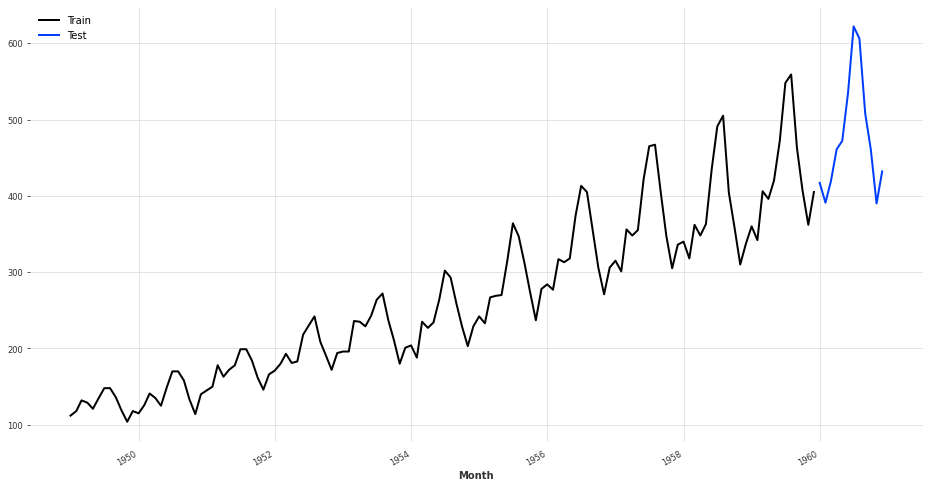

In [4]:
plot_time_series({'Train': train, 'Test': test})

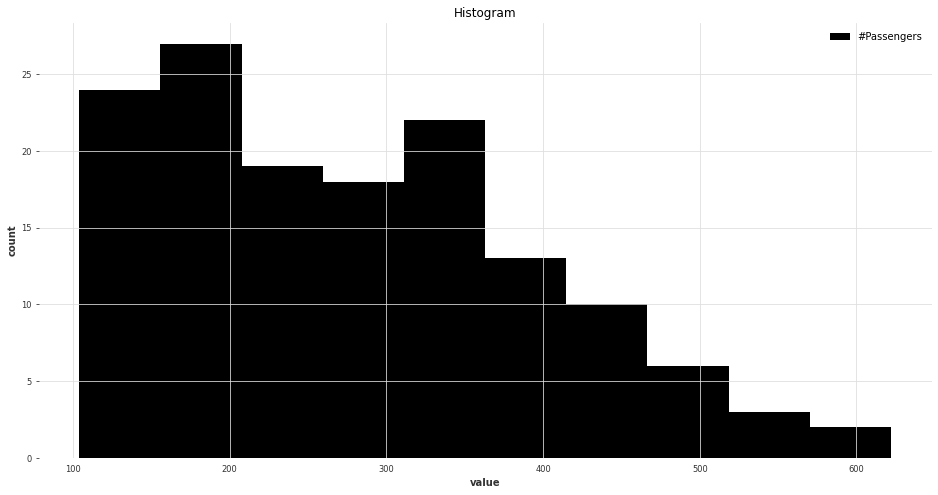

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_hist(airpassengers, ax=ax)

In [6]:
is_data_seasonal(train, 12)

Seasonality of degree 12 found!


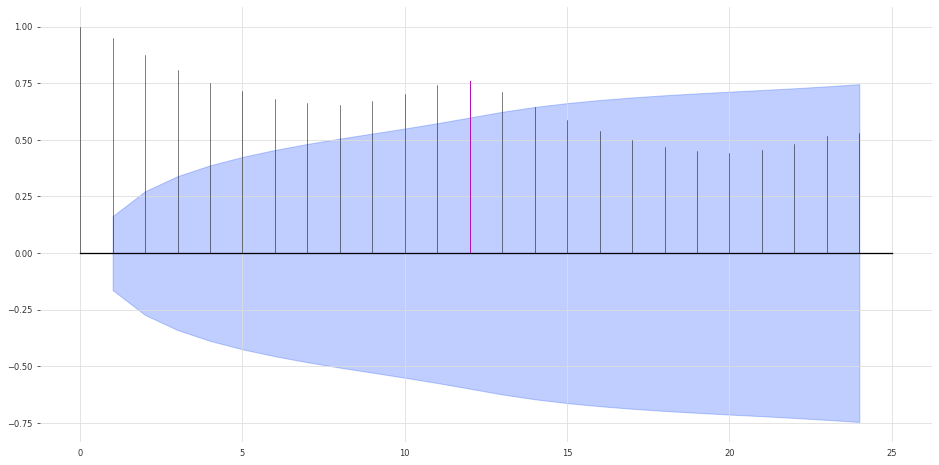

In [7]:
plot_acf(airpassengers, m=12, fig_size=(16, 8))

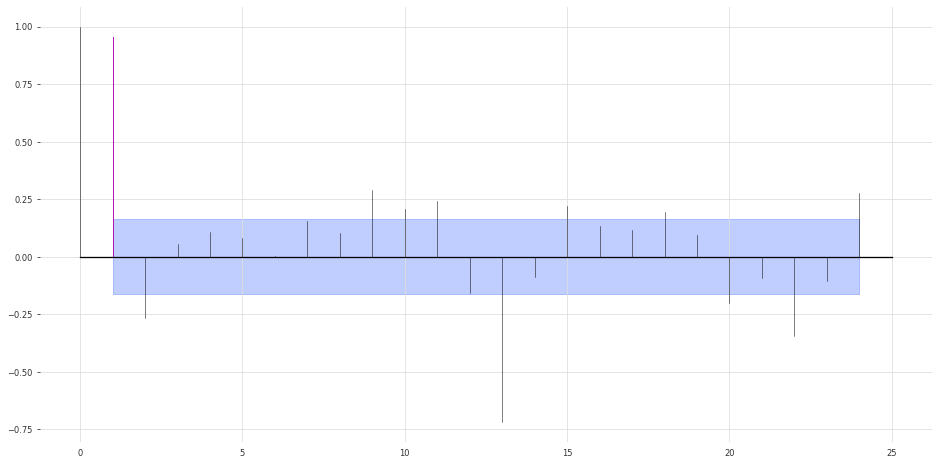

In [8]:
plot_pacf(airpassengers, m=1, fig_size=(16, 8))

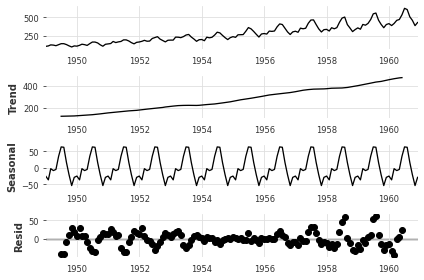

In [9]:
seasonal = seasonal_decompose(airpassengers.pd_dataframe())
_ = seasonal.plot()

## Modellling 

In [10]:
theta_grid = {
    'theta': range(-15, 15, 2),
    'seasonality_period': [12]
}

theta_model = Theta.gridsearch(
    parameters= theta_grid, 
    series=train,
    forecast_horizon=12,
    n_jobs=-1
)[0]

In [11]:
models = (
    NaiveDrift(),
    NaiveSeasonal(K=12),
    AutoARIMA(),
    ExponentialSmoothing(seasonal_periods=12),
    Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    ),
    theta_model
)   

In [12]:
best_model = get_best_model(models, train, mape, stride=6, num_periods=12)

Naive drift model : 16.089572309852823
Naive seasonal model, with K=12 : 10.684849648536433
Auto-ARIMA : 11.880954464963033
Exponential smoothing : 6.069386753502317
Prophet : 7.640370790189145
Theta(-3) : 4.008027980815621


## Evaluating

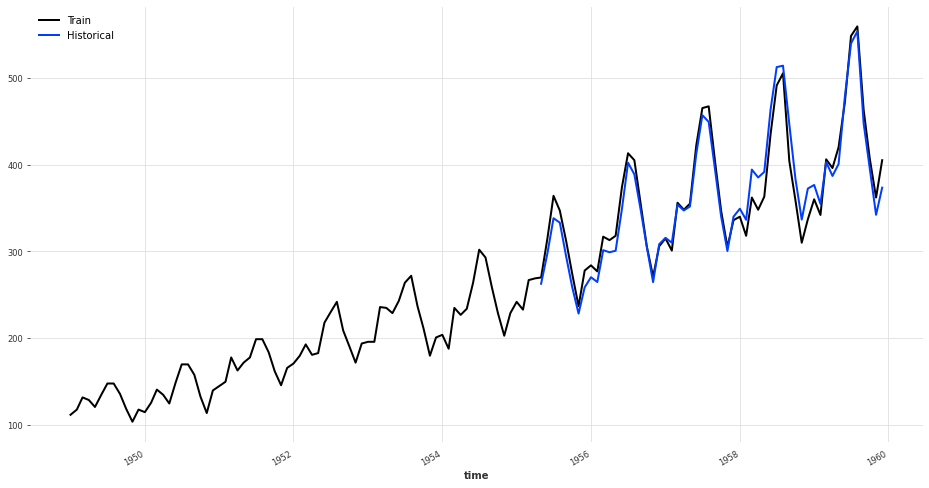

In [13]:
series = best_model.historical_forecasts(train, forecast_horizon=12)
plot_time_series({'Train': train, 'Historical': series})

## Prediction

In [14]:
best_model.fit(train)
pred = best_model.predict(len(test))

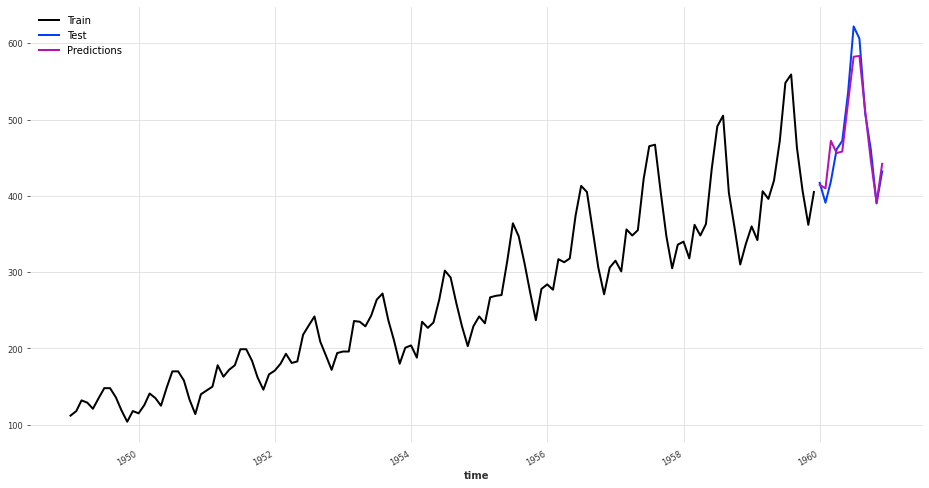

In [15]:
plot_time_series({'Train': train, 'Test': test, 'Predictions': pred})

## Conclusions